# HR-АНАЛИТИКА

## ОПИСАНИЕ ПРОЕКТА

Заказчик проекта - компания "Работа с заботой". HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

## ЗАДАЧА ПРОЕКТА

1. Первая задача - построить модель, которая смодет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2. Вторая задача - построить модель, котрая смодет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## ПЛАН ПРОЕКТА

1. [ЗАДАЧА 1: ПРЕДСКАЗАНИЕ УРОВНЯ УДОВЛЕТВОРЁННОСТИ СОТРУДНИКА](#1)
   
    1.1. [Загрузка и изучение данных](#загрузка1)\
    1.2. [Предобработка данных](#преобработка1)\
    1.3. [Исследовательский анализ данных](#анализ1)\
    1.4. [Подготовка данных](#подготовка1)\
    1.5. [Обучение моделей](#обучение1)\
    1.6. [Вывод](#вывод1)

2. [ЗАДАЧА 2: ПРЕДСКАЗАНИЕ УВОЛЬНЕНИЯ СОТРУДНИКА ИЗ КОМПАНИИ](#2)

    2.1. [Загрузка и изучение данных](#загрузка2)\
    2.2. [Предобработка данных](#преобработка2)\
    2.3. [Исследовательский анализ данных](#анализ2)\
    2.4. [Добавление нового входного признака](#добавление2)\
    2.5. [Подготовка данных](#подготовка2)\
    2.6. [Обучение моделей](#обучение2)\
    2.7. [Вывод](#вывод2)

3. [Общий вывод](#вывод3)

<a id="1"></a>
# ЗАДАЧА 1: ПРЕДСКАЗАНИЕ УРОВНЯ УДОВЛЕТВОРЁННОСТИ СОТРУДНИКА

<a id='загрузка1'></a>
## Загрузка и изучение данных

### Получение данных из файлов, запись в датафреймы

In [1]:
!pip install jupyter_black -q

In [2]:
!pip install phik -q

In [3]:
!pip install -Uq scikit-learn

Импортируем необходимые библиотеки

In [4]:
# импорт pandas и необходимых библиотек
import jupyter_black
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

import warnings

from joblib import dump, load
from scipy import stats as st
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
    r2_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    PolynomialFeatures,
    RobustScaler,
    StandardScaler,
    TargetEncoder,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib.colors import LinearSegmentedColormap
from phik.report import plot_correlation_matrix

warnings.filterwarnings("ignore")

jupyter_black.load()

RANDOM_STATE = 42

Откроем файлы, прочтем и запишем в переменные.

In [5]:
# объявление переменных
train_job_file = "dataset.csv"
test_features = "dataset_features.csv"
test_target = "dataset_target.csv"
user_path = "..."
general_path = "..."


# функция для чтения файлов
def get_read_file(general_path, user_path, file, delimiter):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(path1, sep=delimiter, skipinitialspace=True)
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(path2, sep=delimiter, skipinitialspace=True)
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную train_job_df
train_job_df = get_read_file(general_path, user_path, train_job_file, ",")
train_job_df.name = "train_job_df"
# чтение csv-файла в датафрейм с сохранением в переменную market_money_df
test_features_df = get_read_file(general_path, user_path, test_features, ",")
test_features_df.name = "test_features_df"
# чтение csv-файла в датафрейм с сохранением в переменную market_time_df
test_target_df = get_read_file(general_path, user_path, test_target, ",")
test_target_df.name = "test_target_df"

### Изучение данных

Изучим общую информацию о полученных датафреймах

In [7]:
# объявление списка датафреймов
df_lst = [train_job_df, test_features_df, test_target_df]


# функции для вывода информации о датафреймах
def get_method(method):
    return [getattr(df, method) for df in df_lst]


def get_info(lst, get_method, flag=True):
    i = 0
    for df in df_lst:
        print(f"Датафрейм - {df.name}")
        print("---------")
        if flag:
            display(get_method[i]())
        else:
            get_method[i]()
        print("")
        i += 1


# вывод первых 5-ти строчек датафреймов
get_info(df_lst, get_method("head"))

Датафрейм - train_job_df
---------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Датафрейм - test_features_df
---------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Датафрейм - test_target_df
---------


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
# вывод основной информации о датафреймах
get_info(df_lst, get_method("info"), flag=False)

Датафрейм - train_job_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Датафрейм - test_features_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column             

Обратим внимание на наименования столбцов в датафреймах

In [9]:
# вывод наименований столбцов в датафреймах
for df in df_lst:
    print("")
    print(f"Датафрейм - {df.name}")
    print("---------")
    print(*df.columns.tolist(), sep="\n")


Датафрейм - train_job_df
---------
id
dept
level
workload
employment_years
last_year_promo
last_year_violations
supervisor_evaluation
salary
job_satisfaction_rate

Датафрейм - test_features_df
---------
id
dept
level
workload
employment_years
last_year_promo
last_year_violations
supervisor_evaluation
salary

Датафрейм - test_target_df
---------
id
job_satisfaction_rate


***

***ВЫВОД:***

1. Данные загружены в датафреймы.
2. Наименования столбцов во всех датафреймах имеют стандартный вид.

<a id='преобработка1'></a>
## Предобработка данных

### Предобработка пропусков

Проверим данные на пропущенные значения

In [10]:
# вывод количества пропущенных значений
for df in df_lst:
    print(df.name, end=" - ")
    print(df.isna().sum().sum())

train_job_df - 10
test_features_df - 5
test_target_df - 0


В датафреймах **train_job_df** и **test_features_df** есть пропуски.\
Выведем столбцы с пропусками.

In [11]:
# вывод пропусков по столбцам
train_job_df.isna().sum().sort_values(ascending=False)

dept                     6
level                    4
id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [12]:
# вывод пропусков по столбцам
test_features_df.isna().sum().sort_values(ascending=False)

dept                     3
level                    1
workload                 1
id                       0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Пропуски допущены в признаках `'dept'` и `'level'`

Выведем строки с пропусками

In [13]:
# вывод строк с пропусками
train_job_df.query("dept.isna() | level.isna()")

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [14]:
# вывод строк с пропусками
test_features_df.query("dept.isna() | level.isna()")

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,NaN,middle,medium,3,no,no,4,38400


Возможно большинство сотрудников с уровнем junior работают в определённом отделе.\
Проверим это предположение.

In [15]:
# вывод долей значений столбца по условию
train_job_df[train_job_df["level"] == "junior"]["dept"].value_counts(normalize=True)

dept
sales         0.369174
technology    0.217161
purchasing    0.155191
marketing     0.143008
hr            0.115466
Name: proportion, dtype: float64

Более 36,9% сотрудников с уровнем ***junior*** работают в отделе ***sales***

In [16]:
# вывод долей значений столбца
train_job_df["level"].value_counts(normalize=True)

level
junior    0.473974
middle    0.436436
sinior    0.089590
Name: proportion, dtype: float64

In [17]:
# вывод долей значений столбца
train_job_df["dept"].value_counts(normalize=True)

dept
sales         0.378568
technology    0.216825
purchasing    0.152729
marketing     0.137707
hr            0.114171
Name: proportion, dtype: float64

При этом в датафрейме **train_job_df** для признака `'level'` значение ***junior*** является самым частым.\
Также как и для признака `'dept'` значение ***sales*** является самым частым.

Проверим датафрейм **test_features_df**

In [18]:
# вывод долей значений столбца по условию
test_features_df[test_features_df["level"] == "junior"]["dept"].value_counts(
    normalize=True
)

dept
sales         0.385802
technology    0.223251
purchasing    0.137860
marketing     0.132716
hr            0.120370
Name: proportion, dtype: float64

In [19]:
# вывод долей значений столбца
test_features_df["level"].value_counts(normalize=True)

level
junior    0.487244
middle    0.427214
sinior    0.085543
Name: proportion, dtype: float64

In [20]:
# вывод долей значений столбца
test_features_df["dept"].value_counts(normalize=True)

dept
sales         0.382073
technology    0.227842
marketing     0.139710
purchasing    0.136705
hr            0.113671
Name: proportion, dtype: float64

Для датафрейма **test_features_df** для признака `'level'` значение ***junior*** также является самым частым.\
Также как и для признака `'dept'` значение ***sales*** является самым частым.

Так как признаки `'level'` и `'level'` являются категориальными,\
для заполнения пропущенных значений логично использовать моду — самое частотное значение в выборке.\
Таким образом при создании пайплайна для подготовки данных воспользуемся стратегией заполнения пропусков ***most_frequent***.

### Предобработка дубликатов

Выведем количество явных дубликатов

In [21]:
# вывод количества явных дубликатов датафреймов
for df in df_lst:
    print(df.name, end=" - ")
    print(df.duplicated().sum())

train_job_df - 0
test_features_df - 0
test_target_df - 0


Проверим датафреймы на неявные дубликаты

In [22]:
# объявление функции для вывода значений столбцов со строковым типом данных
def get_str_values(df):
    obj_lst = df.select_dtypes(exclude="number").columns.to_list()
    print(df.name)
    print("---------")
    for col in obj_lst:
        print("---------")
        print(df[col].value_counts())


# вызов функции для датафрейма train_job_df
get_str_values(train_job_df)

train_job_df
---------
---------
dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64
---------
level
junior    1894
middle    1744
sinior     358
Name: count, dtype: int64
---------
workload
medium    2066
low       1200
high       734
Name: count, dtype: int64
---------
last_year_promo
no     3880
yes     120
Name: count, dtype: int64
---------
last_year_violations
no     3441
yes     559
Name: count, dtype: int64


In [23]:
# вызов функции для датафрейма test_features_df
get_str_values(test_features_df)

test_features_df
---------
---------
dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: count, dtype: int64
---------
level
junior    974
middle    854
sinior    171
Name: count, dtype: int64
---------
workload
medium    1043
low        593
high       363
Name: count, dtype: int64
---------
last_year_promo
no     1937
yes      63
Name: count, dtype: int64
---------
last_year_violations
no     1738
yes     262
Name: count, dtype: int64


Дубликатов в данных не обнаружено

### Установка ID как индекса

Так как ID сотрудников - это уникальные значения, зафиксируем их как индексы датафрейма

In [24]:
# установление индексов в датафреймах
train_job_df.set_index("id", drop=True, inplace=True)
test_features_df.set_index("id", drop=True, inplace=True)
test_target_df.set_index("id", drop=True, inplace=True)

***

***ВЫВОД:***

1. В датафреймах **train_job_df** и **test_features_df** есть пропуски в признаках `'dept'` и `'level'`
2. Для заполнения пропущенных значений воспользуемся стратегией заполнения пропусков ***most_frequent*** при создании пайплайна.
3. Дубликатов в данных не обнаружено.
4. Во всех датафреймах были установлены ID покупателей как индексы.

<a id='анализ1'></a>
## Исследовательский анализ данных

### Анализ признаков датафрейма **train_job_df**

#### Анализ количественных признаков датафрейма **train_job_df**

Проведём статистический анализ признаков в датафрейме **train_job_df**

Выведем описательную статистику для количественных признаков датафрейма

In [25]:
# создание списка количественных признаков
train_job_num = train_job_df.select_dtypes(include=["number"]).columns.to_list()

# создание списка категориальных признаков
train_job_cat = train_job_df.select_dtypes(exclude=["number"]).columns.to_list()

# вывод описательной статистики для количественных признаков датасета
train_job_df[[*train_job_num]].describe().round(3)

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000,4000.000,4000.000,4000.000
mean,3.718,3.476,33926.700,0.534
std,2.543,1.009,14900.704,0.225
min,1.000,1.000,12000.000,0.030
25%,2.000,3.000,22800.000,0.360
50%,3.000,4.000,30000.000,0.560
75%,6.000,4.000,43200.000,0.710
max,10.000,5.000,98400.000,1.000


В датафрейме 4 количественных признака: 3 входящих и 1 целевой.\
По признакам `'salary'` (33926,7 и 30000,0) и `'job_satisfaction_rate'` (0,534 и 0,56) среднее и медиана отличаются несущественно,\
хотя стандартное отклонение по обоим признакам большое.\
По признакам `'employment_years'` (3,718 и 3,0) и `'supervisor_evaluation'` (3,476 и 4,0) среднее и медиана имеют существенное отличие.\
И стандартные отклонения по этим признакам тоже велики.

Для большей наглядности построим диаграммы размаха для количественных признаков датасета.

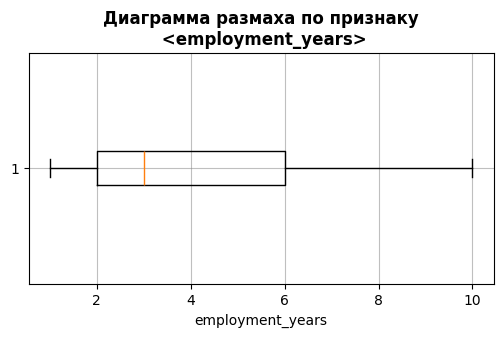

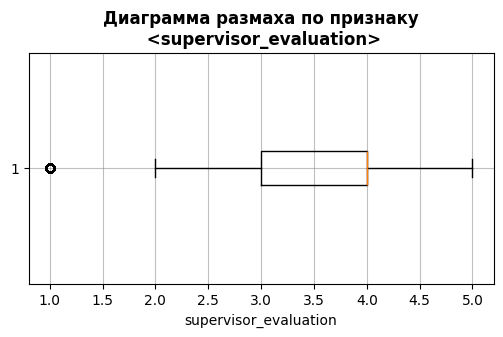

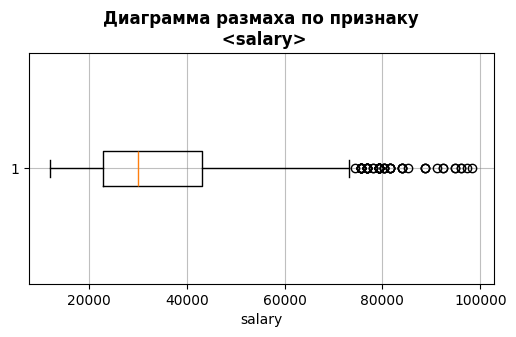

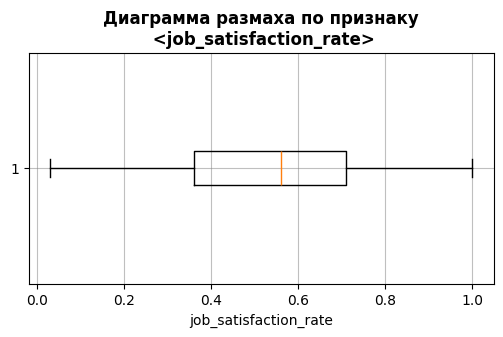

In [26]:
# функция для построения диаграммы размаха
def get_boxplot(df, item):
    plt.rcParams["figure.figsize"] = (
        6,
        3,
    )  # установка параметров графика: размер фигуры

    plt.boxplot(df[item], vert=False)
    plt.title(
        f"Диаграмма размаха по признаку\n <{item}>",
        weight="bold",
    )
    plt.xlabel(f"{item}")
    plt.grid(color="grey", axis="both", alpha=0.5)
    plt.show()


# построение графиков
def set_plot(df, item_lst, plot):
    for item in item_lst:
        plot(df, item)


# построение диаграммы размаха для количественных признаков датасета
set_plot(train_job_df, train_job_num, get_boxplot)

На диаграммах размаха:
- по признаку `'supervisor_evaluation'` - выбросы ниже края статистически значимой выборки
- по признаку `'salary'` - большое количество выбросов выше края статистически значимой выборки

Для непрерывных количественных признаков датафрейма **train_job_df** построим гистограммы распределения

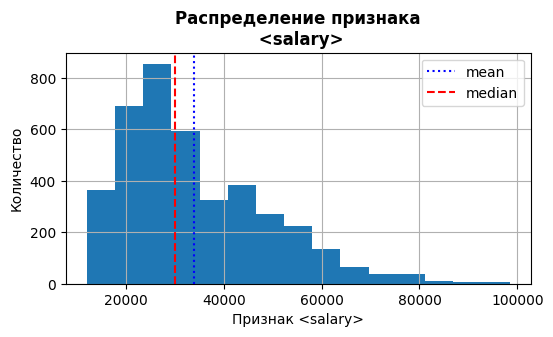

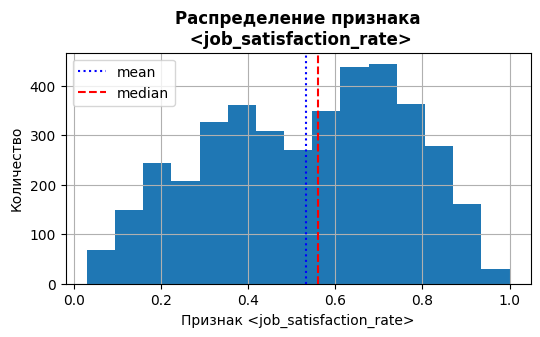

In [27]:
# функция для построения гистограммы
def get_hist(df, item):
    mean_value = df[item].mean()
    median_value = df[item].median()
    df[item].hist(bins=15)
    plt.title(f"Распределение признака\n <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество")
    plt.axvline(x=mean_value, label="mean", color="b", linestyle=":")
    plt.axvline(x=median_value, label="median", color="r", linestyle="--")
    plt.legend()
    plt.show()


# построение гистограммы
set_plot(
    train_job_df,
    train_job_num[2:4],
    get_hist,
)

На диаграммах распределения:
- по признаку `'salary'` - распределение мультимодальное со смещением, с большим "хвостом" справа
- по признаку `'job_satisfaction_rate'` - распределение мультимодальное

Для дискретных количественных признаков датафрейма **train_job_df** построим столбчатые диаграммы

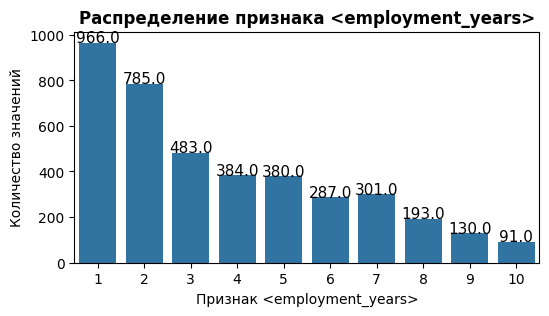

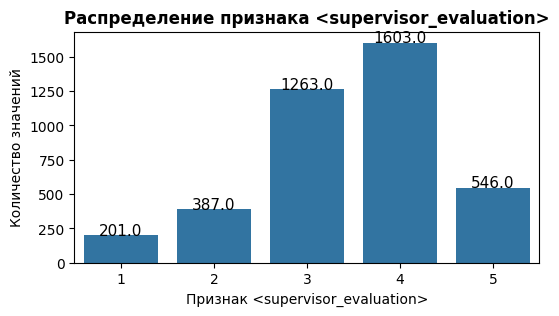

In [28]:
# функция для построения столбчатой диаграммы
def get_countplot(df, item):
    countplt, ax = plt.subplots()
    sns.countplot(x=item, data=df)
    plt.title(f"Распределение признака <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество значений")
    for rect in ax.patches:
        (
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 0.75,
                rect.get_height(),
                horizontalalignment="center",
                fontsize=11,
            )
        )
    plt.show()


# построение столбчатой диаграммы
set_plot(train_job_df, train_job_num[:2], get_countplot)

По признаку `'employment_years'` большая часть значений приходится на 1 год работы,\
и в целом на меньшее количество лет работы.\
По признаку `'supervisor_evaluation'` большая часть оценок - это 4.

#### Анализ категориальных признаков датафрейма **train_job_df**

Выведем описательную статистику для категориальных признаков датасета

In [29]:
# вывод описательной статистики для категориальных признаков датасета
train_job_df[[*train_job_cat]].describe().round(3)

,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


В датафрейме 5 категориальных признаков.\
По 2 значения у признаков:
- `'last_year_promo'`
- `'last_year_violations'`
  
По 3 значения у признаков:
- `'level'`
- `'workload'`
  
5 значений у признака `'dept'`

Признаки `'last_year_promo'` и `'last_year_violations'` - бинарные.\
При предобработке этих признаков применим кодировщик ***OneHotEncoder()***

Для предобработки ранговых признаков `'level'` и `'workload'`\
применим кодировщик ***OrdinalEncoder()***

Для предобработки признака `'dept'` применим кодировщик ***OneHotEncoder()***

Для категориальных признаков датасета построим столбчатые диаграммы

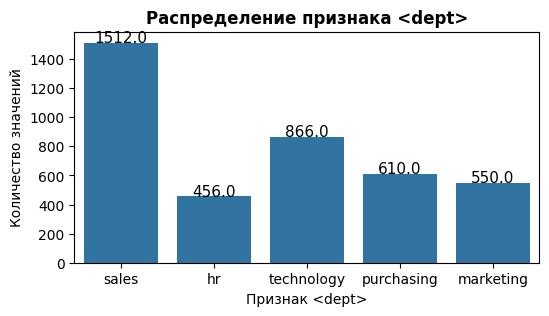

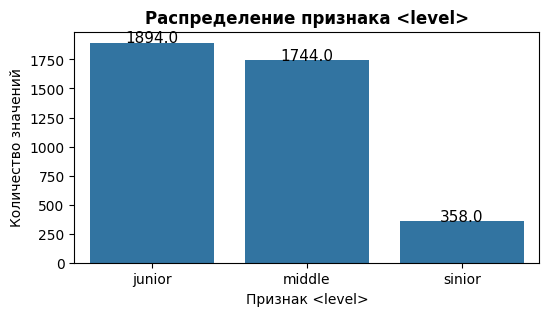

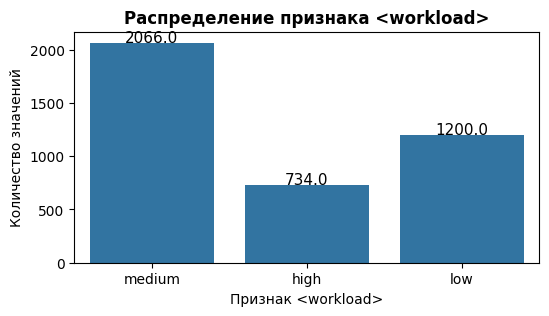

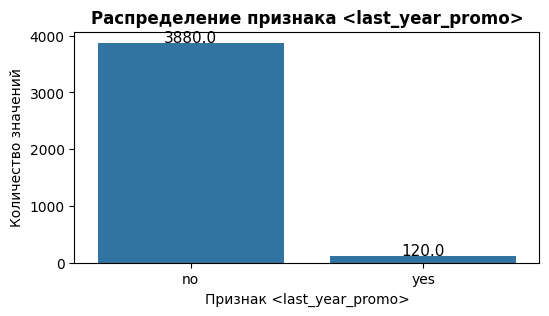

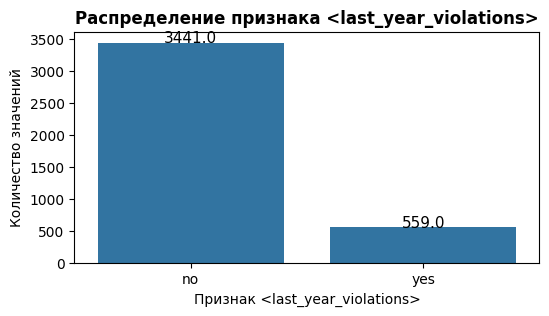

In [30]:
# построение столбчатой диаграммы
set_plot(train_job_df, train_job_cat, get_countplot)

По всем признакам наблюдается дисбаланс классов.

#### Корреляционный анализ признаков датафрейма **train_job_df**

Построим матрицу корреляции Фи

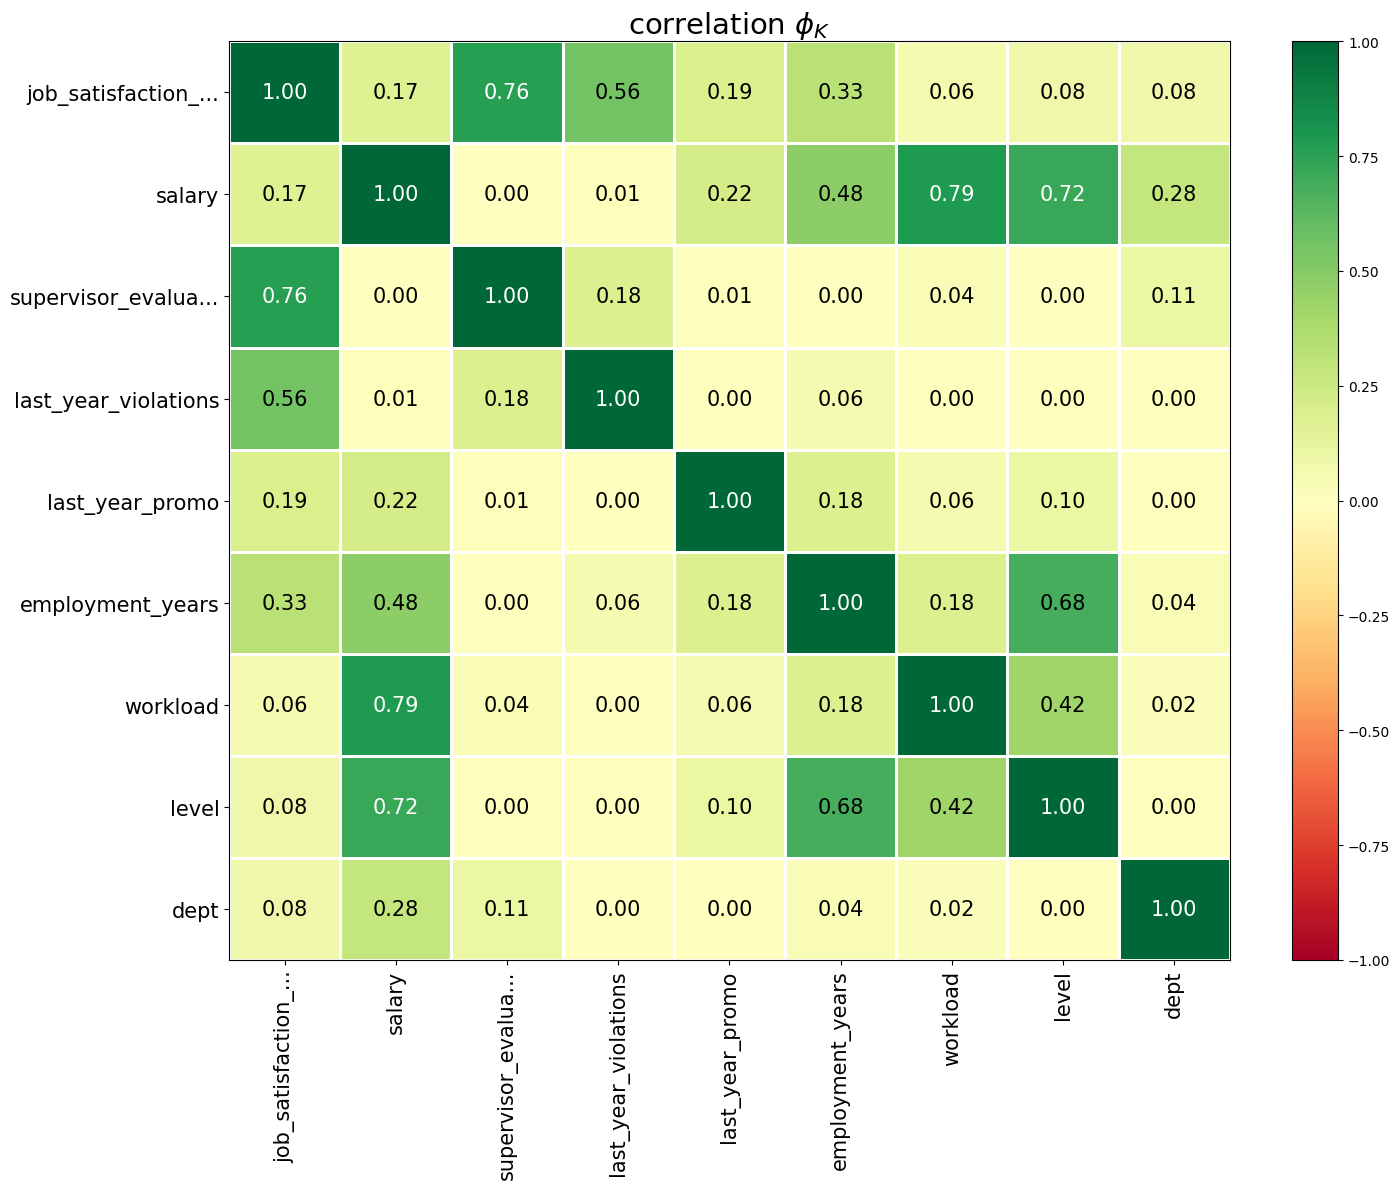

In [31]:
# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = train_job_df.phik_matrix(interval_cols=train_job_num[2:4])

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12),
)

Между целевым признаком `'job_satisfaction_rate'` и входными наблюдается взаимозависимость согласно шкале Чеддока:
- с признаком `'supervisor_evaluation'` - высокая
- с признаком `'last_year_violations'` - заметная
- с признаком `'employment_years'` - умеренная
- с признаком `'salary'` - слабая
- с признаком `'last_year_promo'` - слабая\
Также наблюдается взаимозависимость между входными признаками:
- `'workload'` и `'salary'` - высокая
- `'level'` и `'salary'` - высокая
- `'level'` и `'employment_years'` - заметная\
Мультиколлинеарность между признаками отсутствует.

***

***ВЫВОД:***

1. В датафрейме **train_job_df** 4 количественных признака: 3 входящих и 1 целевой.\
2. По признакам `'salary'` (33926,7 и 30000,0) и `'job_satisfaction_rate'` (0,534 и 0,56) среднее и медиана отличаются несущественно,\
   хотя стандартное отклонение по обоим признакам большое.\
3. По признакам `'employment_years'` (3,718 и 3,0) и `'supervisor_evaluation'` (3,476 и 4,0) среднее и медиана имеют существенное отличие.\
   И стандартные отклонения по этим признакам тоже велики.
4. На диаграммах размаха:
   - по признаку `'supervisor_evaluation'` - выбросы ниже края статистически значимой выборки
   - по признаку `'salary'` - большое количество выбросов выше края статистически значимой выборки
5. На диаграммах распределения:
   - по признаку `'salary'` - распределение мультимодальное со смещением, стремится к нормальному, с большим "хвостом" справа
   - по признаку `'employment_years'` - распределение смещённое вправо с пиком на значении 1
   - по признаку `'supervisor_evaluation'` - распределение смещённое влево с модой на значении 4
   - по признаку `'job_satisfaction_rate'` - распределение мультимодальное, стремится к нормальному
6. В датафрейме 5 категориальных признаков.
7. По 2 значения у признаков:
    - `'last_year_promo'`
    - `'last_year_violations'`
8. По 3 значения у признаков:
    - `'level'`
    - `'workload'` 
9. 5 значений у признака `'dept'`
10. Признаки `'last_year_promo'` и `'last_year_violations'` - бинарные.\
    При предобработке этих признаков применим кодировщик ***OneHotEncoder()***
11. Для предобработки признаков `'level'`, `'workload'` и `'dept'`\
    применим кодировщик ***OrdinalEncoder()***
12. По всем категориальным признакам наблюдается дисбаланс классов.
13. Между целевым признаком `'job_satisfaction_rate'` и входными наблюдается взаимозависимость согласно шкале Чеддока:
    - с признаком `'supervisor_evaluation'` - высокая
    - с признаком `'last_year_violations'` - заметная
    - с признаком `'employment_years'` - умеренная
    - с признаком `'salary'` - слабая
    - с признаком `'last_year_promo'` - слабая\
14. Также наблюдается взаимозависимость между входными признаками:
    - `'workload'` и `'salary'` - высокая
    - `'level'` и `'salary'` - высокая
    - `'level'` и `'employment_years'` - заметная\
15. Мультиколлинеарность между признаками отсутствует.

### Анализ признаков датафрейма **test_features_df**

#### Анализ количественных признаков датафрейма **test_features_df**

Проведём статистический анализ признаков в датафрейме **test_features_df**

Выведем описательную статистику для количественных признаков датафрейма

In [32]:
# создание списка количественных признаков
test_feature_num = test_features_df.select_dtypes(include=["number"]).columns.to_list()

# создание списка категориальных признаков
test_feature_cat = test_features_df.select_dtypes(exclude=["number"]).columns.to_list()

# вывод описательной статистики для количественных признаков датасета
test_features_df[[*test_feature_num]].describe().round(3)

,employment_years,supervisor_evaluation,salary
count,2000.000,2000.000,2000.000
mean,3.666,3.526,34066.800
std,2.537,0.997,15398.437
min,1.000,1.000,12000.000
25%,1.000,3.000,22800.000
50%,3.000,4.000,30000.000
75%,6.000,4.000,43200.000
max,10.000,5.000,96000.000


В датафрейме **test_features_df** 3 количественных признака.\
По всем признакам наблюдается существенная разница между средним и медианой.

Для большей наглядности построим диаграммы размаха для количественных признаков датасета.

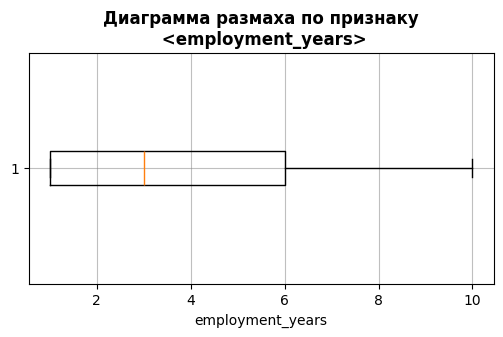

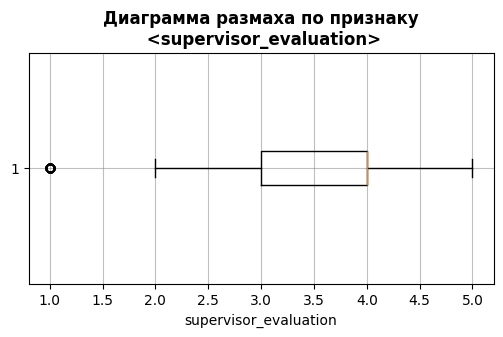

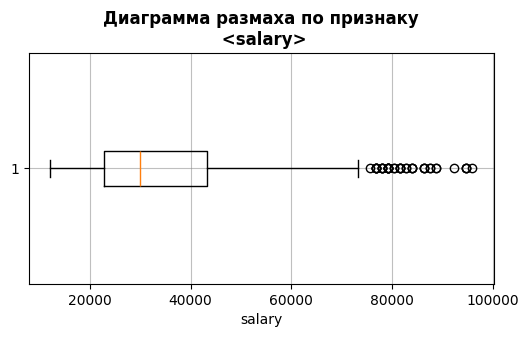

In [33]:
# построение диаграммы размаха для количественных признаков датасета
set_plot(test_features_df, test_feature_num, get_boxplot)

На диаграммах размаха:
- по признаку `'supervisor_evaluation'` - выбросы ниже края статистически значимой выборки
- по признаку `'salary'` - большое количество выбросов выше края статистически значимой выборки

Для непрерывных количественных признаков датафрейма **test_features_df** построим гистограммы распределения

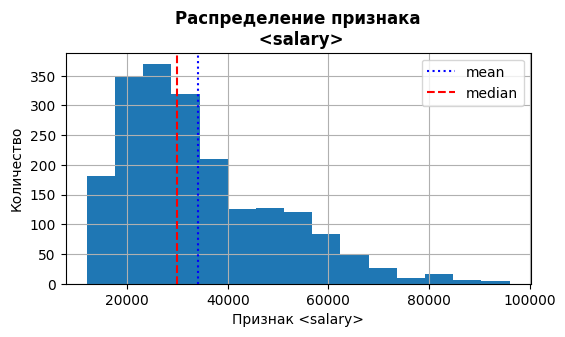

In [34]:
# построение гистограммы
set_plot(test_features_df, test_feature_num[2:4], get_hist)

Для дискретных количественных признаков датафрейма **test_features_df** построим столбчатые диаграммы

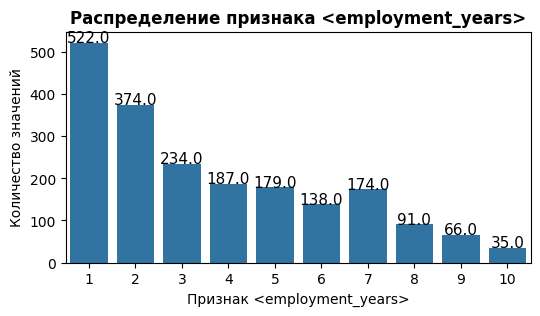

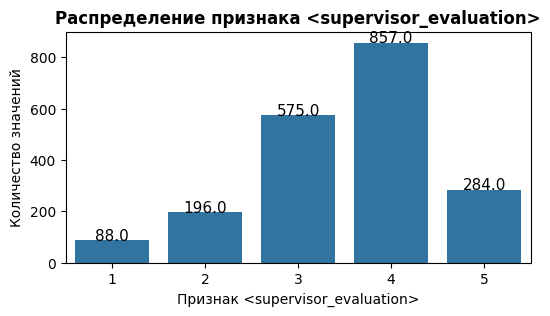

In [35]:
# построение столбчатой диаграммы
set_plot(test_features_df, test_feature_num[:2], get_countplot)

Распределения признаков соответствуют распределению по датафрейму **train_job_df**

#### Анализ категориальных признаков датафрейма **test_features_df**

Выведем описательную статистику для категориальных признаков датасета

In [36]:
# вывод описательной статистики для категориальных признаков датасета
test_features_df[[*test_feature_cat]].describe().round(3)

,dept,level,workload,last_year_promo,last_year_violations
count,1997,1999,1999,2000,2000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


В датафрейме **test_features_df** 5 категориальных признаков, как и в **train_job_df**

Для категориальных признаков датасета построим столбчатые диаграммы

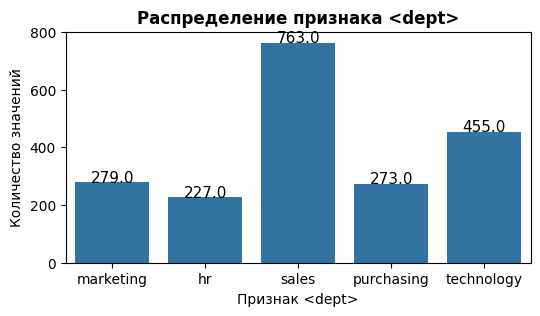

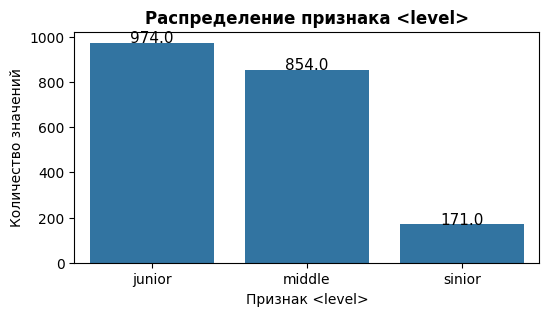

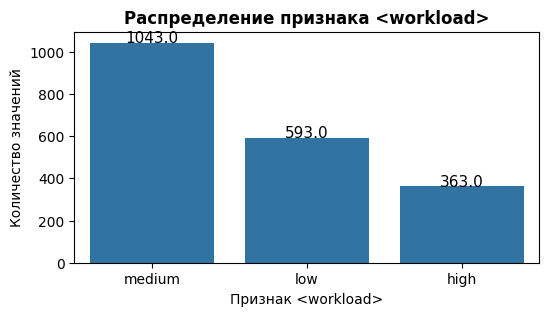

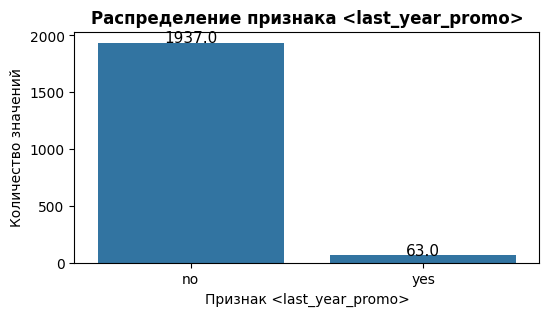

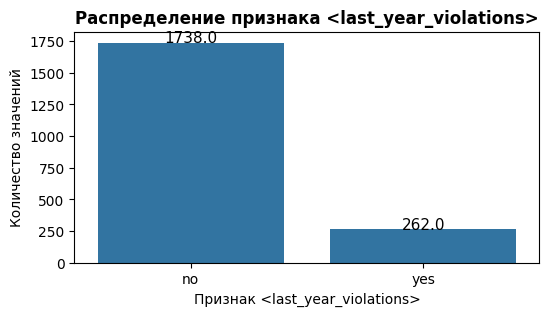

In [37]:
# построение столбчатой диаграммы
set_plot(test_features_df, test_feature_cat, get_countplot)

Наблюдения в тестовой выборке соответствуют наблюдениям в тренировочной выборке.

***

***ВЫВОД:***

1. В датафрейме **test_features_df** 3 количественных признака.
2. По всем признакам наблюдается существенная разница между средним и медианой.
3. На диаграммах размаха:
   - по признаку `'supervisor_evaluation'` - выбросы ниже края статистически значимой выборки
   - по признаку `'salary'` - большое количество выбросов выше края статистически значимой выборки
4. Распределения признаков соответствуют распределению по датафрейму **train_job_df**
5. В датафрейме **test_features_df** 5 категориальных признаков, как и в **train_job_df**
6. Наблюдения в тестовой выборке соответствуют наблюдениям в тренировочной выборке.

### Анализ признаков датафрейма **test_target_df**

Проведём статистический анализ признаков в датафрейме **test_target_df**

Выведем описательную статистику датафрейма

In [38]:
# вывод описательной статистики для количественных признаков датасета
test_target_df.describe().round(3)

,job_satisfaction_rate
count,2000.000
mean,0.549
std,0.220
min,0.030
25%,0.380
50%,0.580
75%,0.720
max,1.000


Описательная статистика целевого признака имеет почти идентичные параметры с таргетом в датафрейме **train_job_df**

Для большей наглядности построим диаграмму размаха.

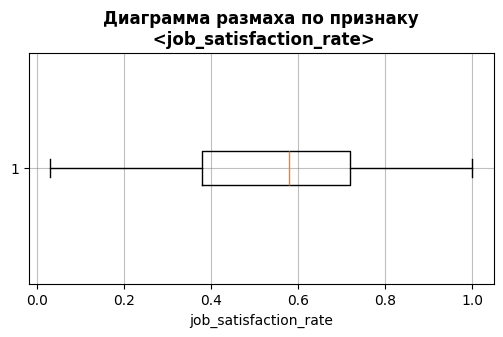

In [39]:
# построение диаграммы размаха для количественных признаков датасета
set_plot(test_target_df, test_target_df.columns.to_list(), get_boxplot)

Построим гистограмму распределения таргета

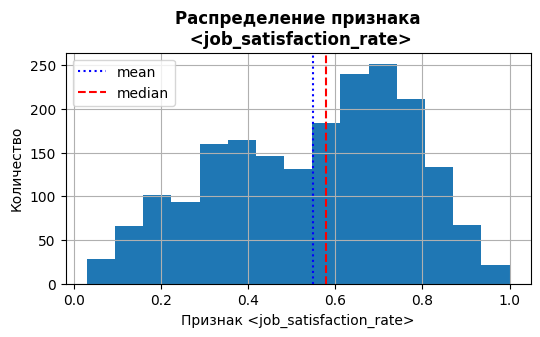

In [40]:
# построение гистограммы
set_plot(test_target_df, test_target_df.columns.to_list(), get_hist)

Распределение мультимодальное, смещённое влево.

***

**ВЫВОД:**

1. Описательная статистика целевого признака имеет почти идентичные параметры с таргетом в датафрейме **train_job_df**
2. Распределение целевого признака мультимодальное, смещённое влево.

<a id='подготовка1'></a>
## Подготовка данных

Так как тагрет - количественный признак, будем решать задачу регрессии.

Для построения модели используем пайплайны.\
Для подготовки данных будем использовать ColumnTransformer.\
Для кодирования категориальных признаков будем использовать кодировщики:
 - OneHotEncoder()
 - OrdinalEncoder()

Для масштабирования количественных признаков будем использовать скейлеры:
 - MinMaxScaler()
 - StandardScaler()
 - RobustScaler()
 - и аргумент "passthrough" - вариант без масштабирования.

Разделим тренировочный датафрейм.

In [41]:
# разделение датафрейма на целевой и входные признаки
X_train_job = train_job_df.drop(columns="job_satisfaction_rate")
y_train_job = train_job_df["job_satisfaction_rate"]

Так как тестовый датафрейм сразу был предоставлен в 2-х файлах: с входными и целевым признаком,\
отсортируем обе части датафрейма по ID.

In [42]:
# сортировка датафреймов
test_target_df = test_target_df.sort_values(by="id")
test_features_df = test_features_df.sort_values(by="id")

Преобразуем таргеты тестовой и тренировочной части в массивы.

In [43]:
# преобразование в массивы NumPy
y_train_job = y_train_job.to_numpy()
y_test_job = test_target_df["job_satisfaction_rate"].to_numpy()

In [44]:
# создание списков с признаками
ohe_columns = ["last_year_promo", "last_year_violations", "dept"]
ord_columns = ["level", "workload"]
num_columns = (
    train_job_df.drop(columns="job_satisfaction_rate")
    .select_dtypes(include=["number"])
    .columns.to_list()
)

In [45]:
# создание pipeline для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            "simpleImputer_ohe",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "ohe",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
        ),
    ]
)

In [46]:
# создание pipeline для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            "simpleImputer_before_ord",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "ord",
            OrdinalEncoder(
                categories=[
                    ["junior", "middle", "sinior"],
                    ["low", "medium", "high"],
                ],
                handle_unknown="use_encoded_value",
                unknown_value=np.nan,
            ),
        ),
        (
            "simpleImputer_after_ord",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
    ]
)

In [47]:
# создание общего pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ("ohe", ohe_pipe, ohe_columns),
        ("ord", ord_pipe, ord_columns),
        ("num", MinMaxScaler(), num_columns),
    ],
    remainder="passthrough",
)

***

***ВЫВОД:***

1. Для подготовки данных были выбраны кодировщики и скейлеры.
2. Датафреймы тестовой части **test_target_df** и **test_features_df** были отсортированы по ID
3. Был создан пайплайн для подготовки данных

<a id="обучение1"></a>
## Обучение моделей

Будем обучать модели с гиперпараметрами:
 - DecisionTreeRegressor() с ***criterion***, ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
 - RandomForestRegressor() с ***max_depth***, ***n_estimators***
 - LinearRegression()
 - GradientBoostingRegressor() с ***loss***, ***max_depth***, ***min_samples_split***, ***min_samples_leaf***

Для подбора лучшей модели с гиперпараметрами будем использовать
 - RandomizedSearchCV()

Для оценки качества работы модели применим кастомную метрику SMAPE

Опишем метрику SMAPE

In [48]:
# функция для метрики SMAPE
def smape(y, y_pred):
    ans = abs(y - y_pred) / ((abs(y) + abs(y_pred)) / 2) * 100
    return np.mean(ans)


# функция для кастомной метрики
smape_scorer = make_scorer(smape, greater_is_better=False)

Создадим итоговый пайплайн

In [49]:
# создание итогового pipeline с инициализацией модели
pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", DecisionTreeRegressor(random_state=RANDOM_STATE)),
    ]
)

Опишем модели с гиперпараметрами

In [50]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        "models": [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        "models__criterion": [
            "squared_error",
            "friedman_mse",
            "absolute_error",
            "poisson",
        ],
        "models__max_depth": range(3, 10),
        "models__min_samples_split": range(2, 10),
        "models__min_samples_leaf": range(2, 10),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели RandomForestRegressor()
    {
        "models": [RandomForestRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(2, 20, 2),
        "models__n_estimators": range(3, 20, 2),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели LinearRegression()
    {
        "models": [LinearRegression()],
        "preprocessor__ord": [OneHotEncoder(drop="first", sparse_output=False)],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели GradientBoostingRegressor()
    {
        "models": [GradientBoostingRegressor()],
        "models__loss": ["squared_error", "absolute_error", "huber", "quantile"],
        "models__max_depth": range(3, 10),
        "models__min_samples_split": range(2, 10),
        "models__min_samples_leaf": range(2, 10),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
]

Выберем лучшую модель с гиперпараметрами с помощью RandomizedSearchCV()

In [52]:
# подбор лучшей модели с гиперпараметрами
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring=smape_scorer,
    n_iter=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rs.fit(X_train_job, y_train_job)

print("Лучшая модель и её параметры:\n\n", rs.best_estimator_)
print(
    f"Качество модели на кросс-валидации по метрике sMAPE - {-(round(rs.best_score_, 3))}"
)

result_rs = smape(y_test_job, rs.predict(test_features_df))
print(f"Качество модели на тестовой выборке по метрике sMAPE - {round(result_rs, 3)}")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                  

Проверим модель на адекватность, используя DummyRegressor()

In [53]:
# инициация dummy-модели
dummy_model = DummyRegressor(strategy="constant", constant=0)
# обучение dummy-модели
dummy_model.fit(X_train_job, y_train_job)
# расчёт SMAPE dummy-модели
smape_dummy = smape(y_test_job, dummy_model.predict(test_features_df))
print(f"smape dummy-модели - {smape_dummy.round(3)}")

smape dummy-модели - 200.0


Метрика smape dummy-модели составляет 200.0, что больше, чем у модели GradientBoostingRegressor (10,997).\
Таким образом, построенная модель GradientBoostingRegressor имеет лучшую предсказательную способность.

***

**ВЫВОД:**

1. Была создана кастомная метрика SMAPE
2. Для обучения были выбраны модели регрессии с гиперпараметрами
3. Модели были обучены в пайплайне с применением RandomizedSearchCV()
4. Лучшая модель - GradientBoostingRegressor() с гиперпараметрами:
   - максимальная глубина дерева max_depth = 7
   - минимальное количество образцов, необходимых для листового узла min_samples_leaf = 2
   - минимальное количество примеров для разделения min_samples_split = 6
5. Метрика SMAPE на тестовой выборке с лучшей моделью - 10,99
6. Выбранная модель была проверена на адекватность с использованием DummyRegressor()

<a id="вывод1"></a>
## Вывод

Модель **DecisionTreeRegressor()** - это серия последовательных шагов, где каждое дерево решений строится индивидуально взависимости от гиперпараметров.
Модель **RandomForestRegressor()** — это группа деревьев решений, объединённых для выдачи одного результата. Обучение всех этих деревьев идёт независимо друг от друга, то есть параллельно. Деревья не передают друг другу никакой информации. При голосовании во время прогнозирования все деревья имеют одинаковый вес.\
В модели **GradientBoostingRegressor()** в отличие от других моделей, обучение построено последовательно. Каждый следующий оценщик получает от предыдущего информацию, на каких образцах датасета этот предыдущий оценщик ошибся сильнее всего. Этим образцам придается более высокий вес в обучении текущего оценщика. Простой алгоритм в бустинге учится исправлять ошибки предыдущих этапов бустинга. В этом и есть преимущество модели бустинга.

<a id="2"></a>
# ЗАДАЧА 2: ПРЕДСКАЗАНИЕ УВОЛЬНЕНИЯ СОТРУДНИКА ИЗ КОМПАНИИ

<a id='загрузка2'></a>
## Загрузка и изучение данных

### Получение данных из файлов, запись в датафреймы

Откроем файлы, прочтем и запишем в переменные.

In [54]:
# объявление переменных
train_quit_file = "train_quit.csv"
test_target_quit = "test_target_quit.csv"
user_path = "/Dev/data_science/12_project"
general_path = "/datasets"


# функция для чтения файлов
def get_read_file(general_path, user_path, file, delimiter):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(path1, sep=delimiter, skipinitialspace=True)
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(path2, sep=delimiter, skipinitialspace=True)
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную train_quit_df
train_quit_df = get_read_file(general_path, user_path, train_quit_file, ",")
train_quit_df.name = "train_quit_df"
# чтение csv-файла в датафрейм с сохранением в переменную market_time_df
test_target_quit_df = get_read_file(general_path, user_path, test_target_quit, ",")
test_target_quit_df.name = "test_target_quit_df"

### Изучение данных

Изучим общую информацию о полученных датафреймах

In [55]:
# объявление списка датафреймов
df_lst = [train_quit_df, test_target_quit_df]

# вывод первых 5-ти строчек датафреймов
get_info(df_lst, get_method("head"))

Датафрейм - train_quit_df
---------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



Датафрейм - test_target_quit_df
---------


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [56]:
# вывод основной информации о датафреймах
get_info(df_lst, get_method("info"))

Датафрейм - train_quit_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None


Датафрейм - test_target_quit_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

***

***ВЫВОД:***

1. Данные загружены в датафреймы.
2. Наименования столбцов во всех датафреймах имеют стандартный вид.

<a id='предобработка2'></a>
## Предобработка данных

### Предобработка пропусков

Проверим данные на пропущенные значения

In [57]:
# вывод количества пропущенных значений
for df in df_lst:
    print(df.name, end=" - ")
    print(df.isna().sum().sum())

train_quit_df - 0
test_target_quit_df - 0


### Предобработка дубликатов

Выведем количество явных дубликатов

In [58]:
# вывод количества явных дубликатов датафреймов
for df in df_lst:
    print(df.name, end=" - ")
    print(df.duplicated().sum())

train_quit_df - 0
test_target_quit_df - 0


Проверим датафреймы на неявные дубликаты

In [59]:
# вызов функции для датафрейма train_quit_df
get_str_values(train_quit_df)

train_quit_df
---------
---------
dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64
---------
level
junior    1949
middle    1694
sinior     357
Name: count, dtype: int64
---------
workload
medium    2118
low       1208
high       674
Name: count, dtype: int64
---------
last_year_promo
no     3887
yes     113
Name: count, dtype: int64
---------
last_year_violations
no     3455
yes     545
Name: count, dtype: int64
---------
quit
no     2872
yes    1128
Name: count, dtype: int64


Дубликатов в данных не обнаружено

### Установка ID как индекса

Так как ID сотрудников - это уникальные значения, зафиксируем их как индексы датафрейма **train_quit_df**.

In [60]:
# установление индексов в датафреймах
train_quit_df.set_index("id", drop=True, inplace=True)
test_target_quit_df.set_index("id", drop=True, inplace=True)

***

***ВЫВОД:***

1. В датафреймах пропуски отсутствуют
2. Дубликатов в данных не обнаружено.
3. Во всех датафреймах были установлены ID покупателей как индексы.

<a id='анализ2'></a>
## Исследовательский анализ данных

### Анализ признаков датафрейма **train_quit_df**

#### Анализ количественных признаков датафрейма **train_quit_df**

In [61]:
# создание списка количественных признаков
train_quit_num = train_quit_df.select_dtypes(include=["number"]).columns.to_list()

# создание списка категориальных признаков
train_quit_cat = train_quit_df.select_dtypes(exclude=["number"]).columns.to_list()

# вывод описательной статистики для количественных признаков датасета
train_quit_df[[*train_quit_num]].describe().round(3)

,employment_years,supervisor_evaluation,salary
count,4000.000,4000.000,4000.000
mean,3.702,3.475,33805.800
std,2.542,1.004,15152.415
min,1.000,1.000,12000.000
25%,2.000,3.000,22800.000
50%,3.000,4.000,30000.000
75%,6.000,4.000,43200.000
max,10.000,5.000,96000.000


Также построим диаграммы размаха

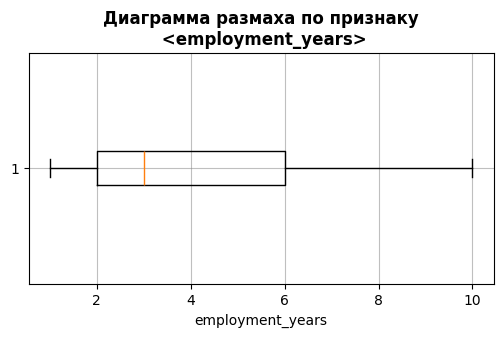

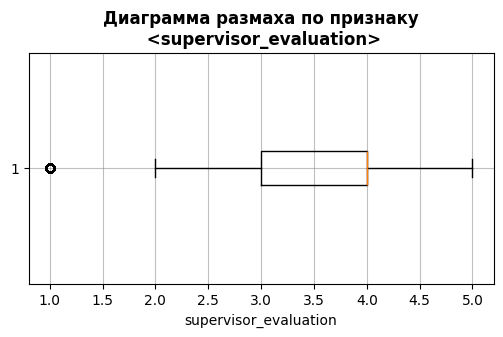

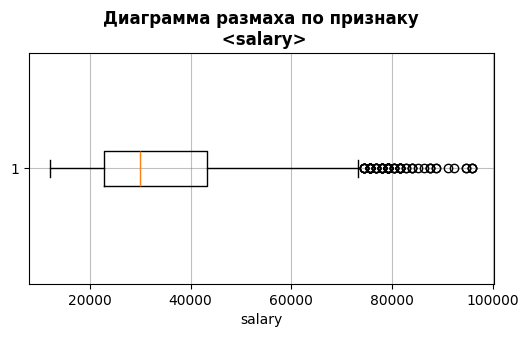

In [62]:
# построение диаграммы размаха для количественных признаков датасета
set_plot(train_quit_df, train_quit_num, get_boxplot)

Построим гистограммы распределения

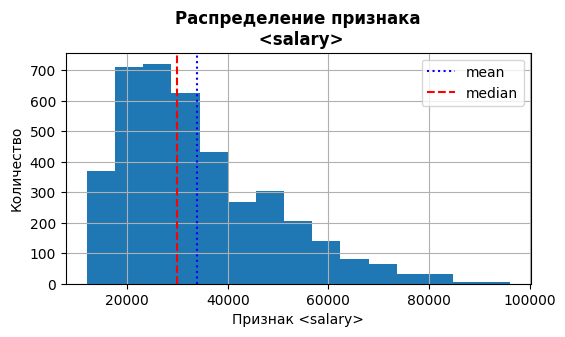

In [63]:
# построение гистограммы
set_plot(train_quit_df, train_quit_num[2:3], get_hist)

Для дискретных количественных признаков датафрейма **train_quit_df** построим столбчатые диаграммы

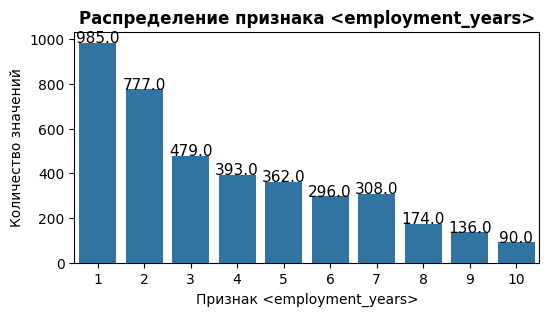

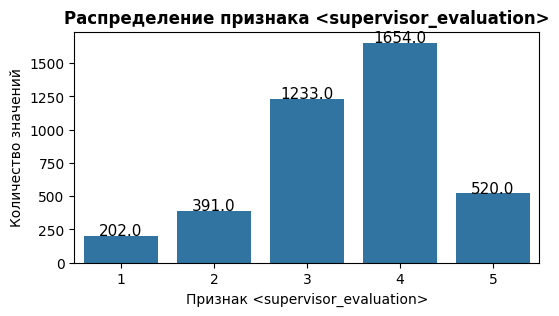

In [64]:
# построение столбчатой диаграммы
set_plot(train_quit_df, train_job_num[:2], get_countplot)

Описание количественных данных датафрейма **train_quit_df** практически не отличается\
от описания количественных данных по датафрейму **train_job_df**

#### Анализ категориальных признаков датафрейма **train_quit_df**

In [65]:
# вывод описательной статистики для категориальных признаков датасета
train_quit_df[[*train_quit_cat]].describe().round(3)

,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872


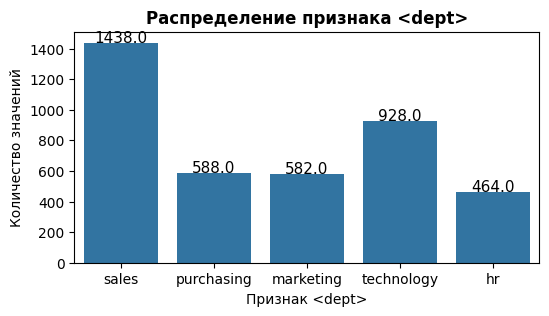

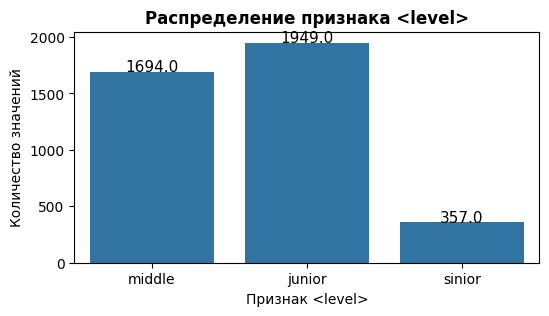

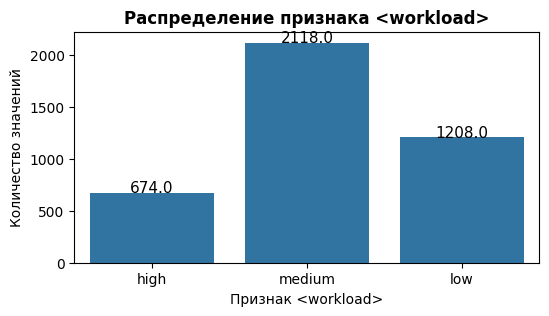

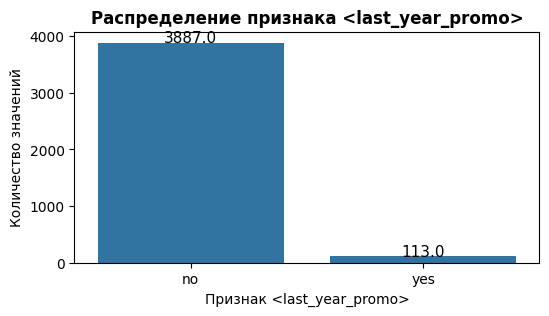

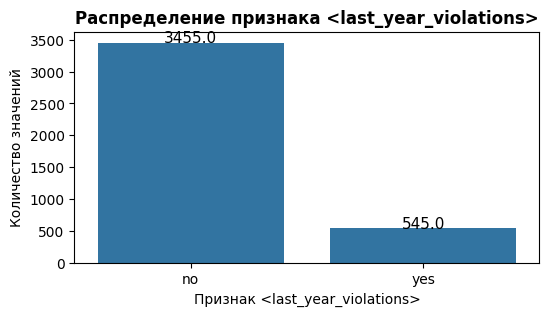

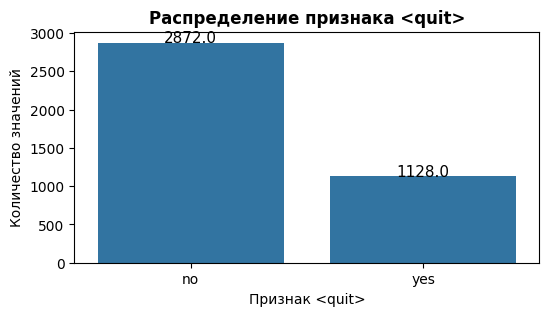

In [66]:
# построение столбчатой диаграммы
set_plot(
    train_quit_df,
    train_quit_cat,
    get_countplot,
)

Описание категориальных данных датафрейма **train_quit_df** практически не отличается\
от описания категориальных данных по датафрейму **train_job_df**\
Целевой признак `'quit'` имеет 2 значения.\
По целевому признаку `'quit'` наблюдается дисбаланс классов.

***

***ВЫВОД:***

1. Описание как количественных, так и категориальных данных датафрейма **train_quit_df**\
практически не отличается от описания данных датафрейма **train_job_df**
2. Целевой признак `'quit'` имеет 2 значения.
3. По целевому признаку `'quit'` наблюдается дисбаланс классов.

### Анализ признаков датафрейма **test_target_quit_df**

In [67]:
# вывод описательной статистики для количественных признаков датасета
test_target_quit_df.describe().round(3)

,quit
count,2000
unique,2
top,no
freq,1436


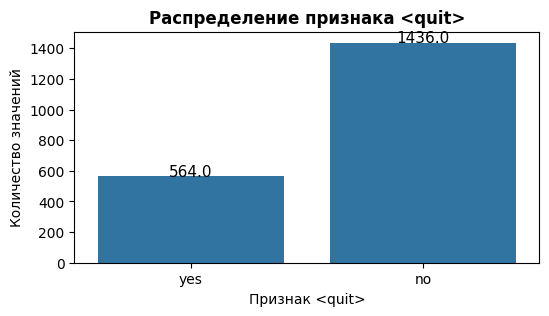

In [68]:
# построение столбчатой диаграммы
set_plot(
    test_target_quit_df,
    test_target_quit_df.columns.to_list(),
    get_countplot,
)

***

***ВЫВОД:***

1. Таргет - категориальный признак
2. Тагрет имеет 2 значения.
3. В классах имеется существенный дисбаланс.

### Портрет уволившегося сотрудника

Нарисуем портрет уволившегося сотрудника.\
Для этого посмотрим на распределения значений по уволенным сотрудникам.

In [85]:
# объявление функции построения countplot
def get_counplot_quit(item):
    countplt, ax = plt.subplots()
    sns.countplot(x=train_quit_df.query('quit == "yes"')[item], orient="v")
    plt.title(
        f"Распределение признака <{item}>\n по уволившимся сотрудникам",
        weight="bold",
    )
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество значений")
    for rect in ax.patches:
        (
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 0.75,
                rect.get_height(),
                horizontalalignment="center",
                fontsize=9,
            )
        )
    plt.show()

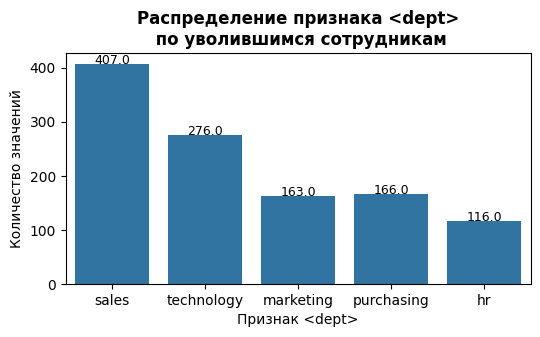

In [86]:
# вывоз функции с агрументом dept
get_counplot_quit("dept")

Как видим, большинство уволившихся работали в отделах ***sales*** и ***technology***\
Это и понятно: эти отделы самые большие по численности.

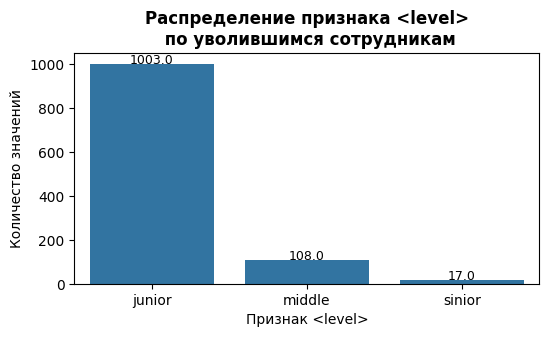

In [87]:
# вывоз функции с агрументом level
get_counplot_quit("level")

Подавляющее большинство уволившихся - джуны

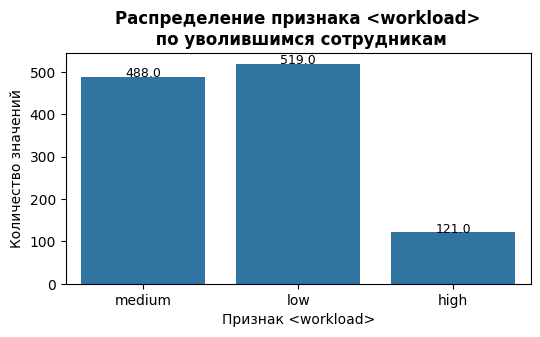

In [88]:
# вывоз функции с агрументом workload
get_counplot_quit("workload")

Большинство уволившихся сотрудников имели низкую и среднюю загруженность.

Обратим внимание также на уровень зарплаты уволившихся работников.

Text(0, 0.5, 'Количество значений')

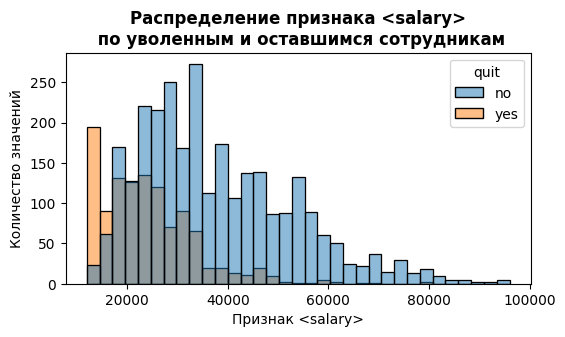

In [89]:
# построения histplot
sns.histplot(train_quit_df, x="salary", hue="quit")
plt.title(
    "Распределение признака <salary>\n по уволенным и оставшимся сотрудникам",
    weight="bold",
)
plt.xlabel("Признак <salary>")
plt.ylabel("Количество значений")

На гистрограмме видно, что уровень заработной платы ушедших сотрудников ниже, чем оставшихся.\
Определим средние значения.

In [90]:
# вывод описательной статистики по условию
train_quit_df.query('quit == "yes"')["salary"].describe().round(2)

count     1128.00
mean     23885.11
std       9351.60
min      12000.00
25%      16800.00
50%      22800.00
75%      27600.00
max      79200.00
Name: salary, dtype: float64

In [91]:
# вывод описательной статистики по условию
train_quit_df.query('quit == "no"')["salary"].describe().round(2)

count     2872.00
mean     37702.23
std      15218.98
min      12000.00
25%      25200.00
50%      34800.00
75%      46800.00
max      96000.00
Name: salary, dtype: float64

Уровень зарплаты уволенных сотрудников ранжируется от 12 тыс. до 79,2 тыс. со средним значением 23,89 тыс.\
Тогда как уровень зарплаты оставшихся - от 12 до 96 тыс. со средним 37,7 тыс.

***

***ПОРТРЕТ УВОЛИВШЕГОСЯ СОТРУДНИКА***

Работал - в отделах ***sales*** и ***technology***\
Имел уровень занимаемой должности - ***junior***\
Имел загруженность - ***medium*** или ***low***\
Имел уровень зарплаты - от 12 тыс. до 79,2 тыс. со средним значением 23,89 тыс.

### Влияние уровня удовлетворённости сотрудника на увольнение

Для того, чтобы выяснить, влияет ли уровень удовлетворённости сотрудника на то, уволится ли он,\
присоединим к тестовой выборке **test_features_df** оба целевых признака из датафреймов **test_target_df** и **test_target_quit_df**

In [92]:
# объединение таблиц
test_df = test_features_df.merge(test_target_df, on="id", how="outer").merge(
    test_target_quit_df, on="id", how="outer"
)

Визуализируем распределения признака `'job_satisfaction_rate'` по уволившимся и оставшимся сотрудникам.

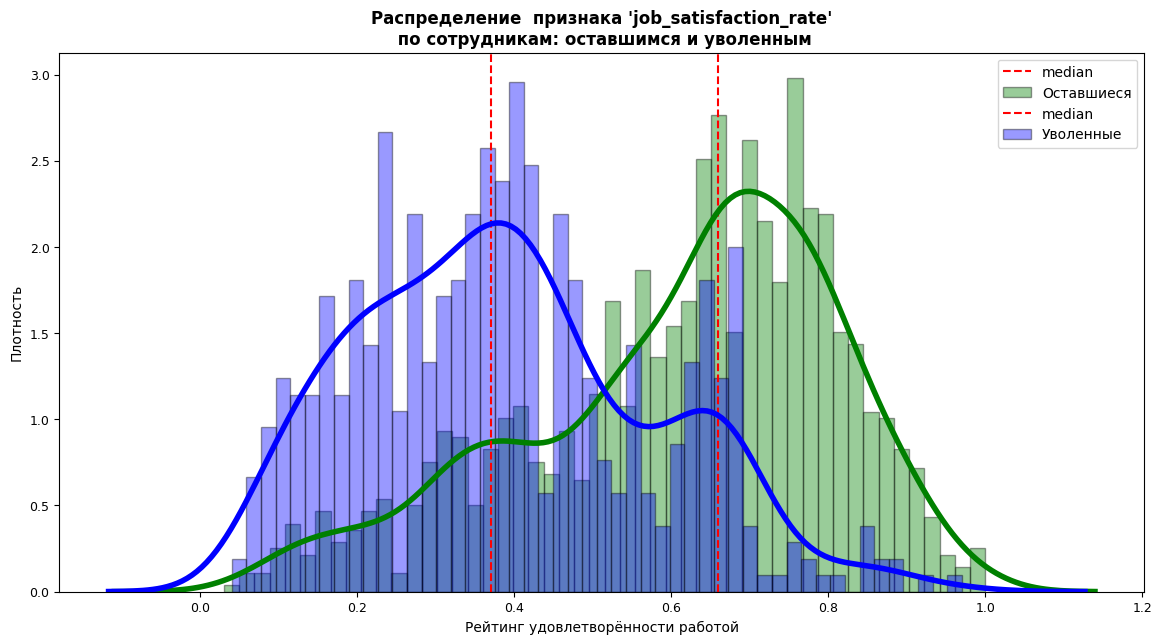

In [93]:
# объявление списка баз
data = [
    test_df.query('quit == "no"')["job_satisfaction_rate"],
    test_df.query('quit == "yes"')["job_satisfaction_rate"],
]
plt.figure(figsize=(14, 7))
# построение гистограммы
for i in range(2):
    median_value = data[i].median()
    plt.axvline(x=median_value, label="median", color="r", linestyle="--")
    colors = ["green", "blue"]
    labels = ["Оставшиеся", "Уволенные"]
    sns.distplot(
        x=data[i],
        hist=True,
        kde=True,
        bins=50,
        color=colors[i],
        hist_kws={"edgecolor": "black"},
        kde_kws={"linewidth": 4},
        label=labels[i],
    )

plt.title(
    "Распределение  признака 'job_satisfaction_rate'\n по сотрудникам: оставшимся и уволенным",
    weight="bold",
)
plt.xlabel("Рейтинг удовлетворённости работой")
plt.ylabel("Плотность")
plt.tick_params(labelsize=9)
plt.legend()
plt.show()

На гистограмме видно, что оставшиеся сотрудники имеют более высокий рейтинг удовлетворённости работой с медианой около 0,66,\
чем уволившиеся - медиана 0,38.

Поэтому утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, истинно.

<a id="добавление2"></a>
## Добавление нового входного признака 'job_satisfaction_rate'

Добавим признак `'job_satisfaction_rate'` к входным признакам тренировочного датафрейма **train_quit_df**\
Для этого воспользуемся предсказаниями лучшей модели из первой задачи.

In [94]:
# предсказание на тренировочной выборке
jsr_pred = rs.predict(train_quit_df.drop(columns="quit"))
# запись предсказания в новый столбец
train_quit_df["job_satisfaction_rate"] = jsr_pred

<a id='подготовка2'></a>
## Подготовка данных

Так как тагрет - категориальный признак, будем решать задачу классификации.

Для построения модели используем пайплайны.\
Для подготовки данных будем использовать ColumnTransformer.\
Для кодирования категориальных признаков будем использовать кодировщики:
 - OneHotEncoder()
 - OrdinalEncoder()

Для масштабирования количественных признаков будем использовать скейлеры:
 - MinMaxScaler()
 - StandardScaler()
 - RobustScaler()
 - и аргумент "passthrough" - вариант без масштабирования.

Целевой признак кодируем кодировщиком
 - LabelEncoder()

Разделим тренировочный датафрейм.

In [95]:
# разделение датафрейма на целевой и входные признаки
X_train_quit = train_quit_df.drop(columns="quit")
y_train_quit = train_quit_df["quit"]

Так как тестовый датафрейм сразу был предоставлен в 2-х файлах: с входными и целевым признаком,\
отсортируем таргетную часть датафрейма по ID. Часть с входными признаками была отсортирована ранее.

In [96]:
# сортировка датафрейма
test_target_quit_df = test_target_quit_df.sort_values(by="id")

Так как к тренировочной выборке был присоединён признак `'job_satisfaction_rate'` как входной,\
присоединим его и к тестовой выборке.

In [97]:
# объединение таблиц
test_features_full_df = test_features_df.merge(test_target_df, on="id", how="outer")

Кодируем таргеты тестовой и тренировочной кодировщиком LabelEncoder().

In [98]:
# кодирование целевого признака
y_label = LabelEncoder()
y_train_label = y_label.fit_transform(y_train_quit)
y_test_label = y_label.transform(test_target_quit_df)

In [99]:
# создание списков с признаками
ohe_columns = ["last_year_promo", "last_year_violations", "dept"]
ord_columns = ["level", "workload"]
num_columns = X_train_quit.select_dtypes(include=["number"]).columns.to_list()

In [100]:
# создание pipeline для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            "simpleImputer_ohe",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "ohe",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
        ),
    ]
)

In [101]:
# создание pipeline для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            "simpleImputer_before_ord",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "ord",
            OrdinalEncoder(
                categories=[
                    ["junior", "middle", "sinior"],
                    ["low", "medium", "high"],
                ],
                handle_unknown="use_encoded_value",
                unknown_value=np.nan,
            ),
        ),
        (
            "simpleImputer_after_ord",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
    ]
)

In [102]:
# создание общего pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ("ohe", ohe_pipe, ohe_columns),
        ("ord", ord_pipe, ord_columns),
        ("num", MinMaxScaler(), num_columns),
    ],
    remainder="passthrough",
)

***

***ВЫВОД:***

1. Для подготовки данных были выбраны кодировщики и скейлеры.
2. Датафреймы тестовой части **test_target_quit_df** и **test_features_df** были отсортированы по ID
3. Был создан пайплайн для подготовки данных

<a id="обучение2"></a>
## Обучение моделей

Будем обучать модели с гиперпараметрами:
 - DecisionTreeClassifier() с ***max_depth***, ***max_features***
 - KNeighborsClassifier() с ***n_neighbors***
 - LogisticRegression() с ***С***
 - GradientBoostingClassifier() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***

Для подбора лучшей модели с гиперпараметрами будем использовать
 - RandomizedSearchCV()

Для оценки качества работы модели применим метрику ROC_AUC

Создадим итоговый пайплайн

In [103]:
# создание итогового pipeline с инициализацией модели
pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]
)

Опишем модели с гиперпараметрами

In [104]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        "models": [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        "models__max_depth": range(2, 5),
        "models__max_features": range(2, 5),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели KNeighborsClassifier()
    {
        "models": [KNeighborsClassifier()],
        "models__n_neighbors": range(2, 5),
        "preprocessor__ord": [OneHotEncoder(drop="first", sparse_output=False)],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели LogisticRegression()
    {
        "models": [
            LogisticRegression(
                random_state=RANDOM_STATE,
                solver="liblinear",
                penalty="l1",
                class_weight="balanced",
            )
        ],
        "models__C": range(1, 5),
        "preprocessor__ord": [OneHotEncoder(drop="first", sparse_output=False)],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели GradientBoostingClassifier()
    {
        "models": [GradientBoostingClassifier()],
        "models__max_depth": range(3, 10),
        "models__min_samples_split": range(2, 10),
        "models__min_samples_leaf": range(2, 10),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
]

Выберем лучшую модель с гиперпараметрами с помощью RandomizedSearchCV()

In [106]:
# подбор лучшей модели с гиперпараметрами
rs2 = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring="roc_auc",
    n_iter=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rs2.fit(X_train_quit, y_train_label)

print("Лучшая модель и её параметры:\n\n", rs2.best_estimator_)
print(
    f"Качество модели на кросс-валидации по метрике ROC_AUC - {round(rs2.best_score_, 3)}"
)
y_test_pred = rs2.predict_proba(test_features_full_df)
print(
    f"Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_label, y_test_pred[:,1]), 3)}"
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                  

Проверим модель на адекватность, используя DummyClassifier()

In [108]:
# инициация dummy-модели
dummy_model = DummyClassifier(strategy="constant", constant=0)
# обучение dummy-модели
dummy_model.fit(X_train_quit, y_train_label)
# расчёт SMAPE dummy-модели
roc_auc_dummy = roc_auc_score(
    y_test_label, dummy_model.predict_proba(test_features_full_df)[:, 1]
)
print(f"smape dummy-модели - {round(roc_auc_dummy, 3)}")

smape dummy-модели - 0.5


Метрика roc_auc dummy-модели составляет 0.5, что меньше, чем у модели GradientBoostingClassifier (0.935).\
Таким образом, построенная модель GradientBoostingClassifier имеет лучшую предсказательную способность.

***

***ВЫВОД:***

1. Для обучения были выбраны модели классификации с гиперпараметрами
2. Модели были обучены в пайплайне с применением RandomizedSearchCV()
3. Лучшая модель - GradientBoostingClassifier() с гиперпараметрами:
   - минимальное количество образцов, необходимых для листового узла min_samples_leaf = 4
   - минимальное количество примеров для разделения min_samples_split = 3
4. Метрика ROC-AUC на тестовой выборке с лучшей моделью - 0,935
6. Выбранная модель была проверена на адекватность с использованием DummyClassifier()

<a id="вывод2"></a>
## Вывод

Модель **DecisionTreeClassifier()** - это серия последовательных шагов, где каждое дерево решений строится индивидуально взависимости от гиперпараметров.
Модель **KNeighborsClassifier()** —  это алгоритм, основанный на методе K-ближайших соседей, который использует для классификации сходство между примерами данных.\
В модели **GradientBoostingClassifier()** в отличие от других моделей, обучение построено последовательно. Каждый следующий оценщик получает от предыдущего информацию, на каких образцах датасета этот предыдущий оценщик ошибся сильнее всего. Этим образцам придается более высокий вес в обучении текущего оценщика. Простой алгоритм в бустинге учится исправлять ошибки предыдущих этапов бустинга. В этом и есть преимущество модели бустинга.

<a id="вывод3"></a>
# Общий вывод

**ВХОДНЫЕ ДАННЫЕ**

1. Исследование проведено на основе данных компании "Работа с заботой"
2. По ЗАДАЧЕ 1 данные представлены файлами:
    - Тренировочная выборка train_job_satisfaction_rate.csv
    - Входные признаки тестовой выборки test_features.csv
    - Целевой признак тестовой выборки test_target_job_satisfaction_rate.csv
3. По ЗАДАЧЕ 2 данные представлены файлами:
    - Тренировочная выборка train_quit.csv
    - Входные признаки тестовой выборки те же test_features.csv
    - Целевой признак тестовой выборки test_target_quit.csv
4. Данные загружены в датафреймы.
5. Наименования столбцов во всех датафреймах имеют стандартный вид.

**НА ЭТАПЕ ПРЕОБРАБОТКИ ДАННЫХ**

1. В датафреймах **train_job_df** и **test_features_df** есть пропуски в признаках `'dept'` и `'level'`
2. Для заполнения пропущенных значений воспользуемся стратегией заполнения пропусков ***most_frequent*** при создании пайплайна.
3. Дубликатов в данных не обнаружено.
4. Во всех датафреймах были установлены ID покупателей как индексы.

**НА ЭТАПЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА ДАННЫХ**

По датафреймам было выявлено:

**датафрейм** ***train_job_df***
 - по количественным признакам:
1. В датафрейме **train_job_df** 4 количественных признака: 3 входящих и 1 целевой.\
2. По признакам `'salary'` (33926,7 и 30000,0) и `'job_satisfaction_rate'` (0,534 и 0,56) среднее и медиана отличаются несущественно,\
   хотя стандартное отклонение по обоим признакам большое.\
3. По признакам `'employment_years'` (3,718 и 3,0) и `'supervisor_evaluation'` (3,476 и 4,0) среднее и медиана имеют существенное отличие.\
   И стандартные отклонения по этим признакам тоже велики.
4. На диаграммах размаха:
   - по признаку `'supervisor_evaluation'` - выбросы ниже края статистически значимой выборки
   - по признаку `'salary'` - большое количество выбросов выше края статистически значимой выборки
5. На диаграммах распределения:
   - по признаку `'salary'` - распределение мультимодальное со смещением, стремится к нормальному, с большим "хвостом" справа
   - по признаку `'employment_years'` - распределение смещённое вправо с пиком на значении 1
   - по признаку `'supervisor_evaluation'` - распределение смещённое влево с модой на значении 4
   - по признаку `'job_satisfaction_rate'` - распределение мультимодальное, стремится к нормальному
 - по категориальным признакам:
1. В датафрейме 5 категориальных признаков.
2. По 2 значения у признаков:
    - `'last_year_promo'`
    - `'last_year_violations'`
3. По 3 значения у признаков:
    - `'level'`
    - `'workload'` 
4. 5 значений у признака `'dept'`
5. Признаки `'last_year_promo'` и `'last_year_violations'` - бинарные.\
    При предобработке этих признаков применим кодировщик ***OneHotEncoder()***
6. Для предобработки признаков `'level'`, `'workload'` и `'dept'`\
    применим кодировщик ***OrdinalEncoder()***
7. По всем категориальным признакам наблюдается дисбаланс классов.
 - по матрице корреляции:
1. Между целевым признаком `'job_satisfaction_rate'` и входными наблюдается взаимозависимость согласно шкале Чеддока:
    - с признаком `'supervisor_evaluation'` - высокая
    - с признаком `'last_year_violations'` - заметная
    - с признаком `'employment_years'` - умеренная
    - с признаком `'salary'` - слабая
    - с признаком `'last_year_promo'` - слабая
2. Также наблюдается взаимозависимость между входными признаками:
    - `'workload'` и `'salary'` - высокая
    - `'level'` и `'salary'` - высокая
    - `'level'` и `'employment_years'` - заметная
3. Мультиколлинеарность между признаками отсутствует.

**датафрейм** ***test_features_df***
 - по количественным признакам:
1. В датафрейме **test_features_df** 3 количественных признака.
2. По всем признакам наблюдается существенная разница между средним и медианой.
3. На диаграммах размаха:
   - по признаку `'supervisor_evaluation'` - выбросы ниже края статистически значимой выборки
   - по признаку `'salary'` - большое количество выбросов выше края статистически значимой выборки
4. Распределения признаков соответствуют распределению по датафрейму **train_job_df**

 - по категориальным признакам:
1. В датафрейме **test_features_df** 5 категориальных признаков, как и в **train_job_df**
2. Наблюдения в тестовой выборке соответствуют наблюдениям в тренировочной выборке.

**датафрейм** ***test_target_df***
1. Описательная статистика целевого признака имеет почти идентичные параметры с таргетом в датафрейме **train_job_df**
2. Распределение целевого признака мультимодальное, смещённое влево.

**датафрейм** ***train_quit_df***
1. Описание как количественных, так и категориальных данных датафрейма **train_quit_df**\
практически не отличается от описания данных датафрейма **train_job_df**
2. Целевой признак `'quit'` имеет 2 значения.
3. По целевому признаку `'quit'` наблюдается дисбаланс классов.

**датафрейм** ***test_target_quit_df***
1. Таргет - категориальный признак
2. Тагрет имеет 2 значения.
3. В классах имеется существенный дисбаланс.

ТАКЖЕ:
1. Был нарисован портрет уволившегося сотрудника:
   1. Работал - в отделах sales и technology
   2. Имел уровень занимаемой должности - junior
   3. Имел загруженность - medium или low
   4. Имел уровень зарплаты - от 12 тыс. до 79,2 тыс. со средним значением 23,89 тыс.
2. Была дана оценка влияния уровня удовлетворённости сотрудника на то, уволится ли он:
   1. Оставшиеся сотрудники имеют более высокий рейтинг удовлетворённости работой с медианой около 0,66,
      чем уволившиеся - медиана 0,38.
   2. Утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, истинно.

**НА ЭТАПЕ ПОДГОТОВКИ ДАННЫХ**

**По ЗАДАЧЕ 1**

1. Так как тагрет - количественный признак, будем решать задачу регрессии.
2. Для построения модели используем пайплайны.
3. Для подготовки данных были выбраны кодировщики:
    - OneHotEncoder()
    - OrdinalEncoder()
4. Для подготовки данных были выбраны скейлеры:
    - MinMaxScaler()
    - StandardScaler()
    - RobustScaler()
    - и аргумент "passthrough" - вариант без масштабирования.
5. Датафреймы тестовой части **test_target_df** и **test_features_df** были отсортированы по ID
6. Был создан пайплайн для подготовки данных

**По ЗАДАЧЕ 2**

1. Так как тагрет - категориальный признак, будем решать задачу классификации.
2. Для построения модели используем пайплайны.\
3. Для подготовки данных были выбраны кодировщики:
    - OneHotEncoder()
    - OrdinalEncoder()
4. Для подготовки данных были выбраны скейлеры:
    - MinMaxScaler()
    - StandardScaler()
    - RobustScaler()
    - и аргумент "passthrough" - вариант без масштабирования.
5. Целевой признак кодируем кодировщиком
    - LabelEncoder()
6. Датафрейм таргета **test_target_quit_df** был отсортирован по ID
7. Был создан пайплайн для подготовки данных

**НА ЭТАПЕ ОБУЧЕНИЯ МОДЕЛЕЙ**

**По ЗАДАЧЕ 1**

1. Была создана кастомная метрика SMAPE
2. Для обучения были выбраны модели регрессии с гиперпараметрами:
   - DecisionTreeRegressor() с ***criterion***, ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
   - RandomForestRegressor() с ***max_depth***, ***n_estimators***
   - LinearRegression()
   - GradientBoostingRegressor() с ***loss***, ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
3. Модели были обучены в пайплайне с применением RandomizedSearchCV()
4. Лучшая модель - GradientBoostingRegressor() с гиперпараметрами:
   - максимальная глубина дерева max_depth = 7
   - минимальное количество образцов, необходимых для листового узла min_samples_leaf = 2
   - минимальное количество примеров для разделения min_samples_split = 6
5. Метрика SMAPE на тестовой выборке с лучшей моделью - 10,99
6. Выбранная модель была проверена на адекватность с использованием DummyRegressor()

**По ЗАДАЧЕ 2**

1. Для обучения были выбраны модели классификации с гиперпараметрами:
   - DecisionTreeClassifier() с ***max_depth***, ***max_features***
   - KNeighborsClassifier() с ***n_neighbors***
   - LogisticRegression() с ***С***
   - GradientBoostingClassifier() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
3. Модели были обучены в пайплайне с применением RandomizedSearchCV()
4. Лучшая модель - GradientBoostingClassifier() с гиперпараметрами:
   - минимальное количество образцов, необходимых для листового узла min_samples_leaf = 8
   - минимальное количество примеров для разделения min_samples_split = 5
5. Метрика ROC-AUC на тестовой выборке с лучшей моделью - 0,933
6. Выбранная модель была проверена на адекватность с использованием DummyClassifier()

**ВЫВОД ПО МОДЕЛЯМ**

**По ЗАДАЧЕ 1**

Модель **DecisionTreeRegressor()** - это серия последовательных шагов, где каждое дерево решений строится индивидуально взависимости от гиперпараметров.\
Модель **RandomForestRegressor()** — это группа деревьев решений, объединённых для выдачи одного результата. Обучение всех этих деревьев идёт независимо друг от друга, то есть параллельно. Деревья не передают друг другу никакой информации. При голосовании во время прогнозирования все деревья имеют одинаковый вес.\
В модели **GradientBoostingRegressor()** в отличие от других моделей, обучение построено последовательно. Каждый следующий оценщик получает от предыдущего информацию, на каких образцах датасета этот предыдущий оценщик ошибся сильнее всего. Этим образцам придается более высокий вес в обучении текущего оценщика. Простой алгоритм в бустинге учится исправлять ошибки предыдущих этапов бустинга. В этом и есть преимущество модели бустинга.

**По ЗАДАЧЕ 2**

Модель **DecisionTreeClassifier()** - это серия последовательных шагов, где каждое дерево решений строится индивидуально взависимости от гиперпараметров.\
Модель **KNeighborsClassifier()** — это алгоритм, основанный на методе K-ближайших соседей, который использует для классификации сходство между примерами данных.\
В модели **GradientBoostingClassifier()** в отличие от других моделей, обучение построено последовательно. Каждый следующий оценщик получает от предыдущего информацию, на каких образцах датасета этот предыдущий оценщик ошибся сильнее всего. Этим образцам придается более высокий вес в обучении текущего оценщика. Простой алгоритм в бустинге учится исправлять ошибки предыдущих этапов бустинга. В этом и есть преимущество модели бустинга.

**ВЫВОД**

1. Руководству компании следует обратить пристальное внимание на сотрудников, соответствующих портрету уволенного.
2. Необходимо повышать уровень удовлетворённости работой у таких сотрудников.